In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
train = pd.read_csv('train_clean.csv')
val = pd.read_csv('val_clean.csv')
train

,review_id,review,rating,review_clean,count
0,0,Ga disappointed neat products .. Meletot Hilsn...,1,ga disappointed neat products . meletot hilsny...,11
1,1,"Rdtanya replace broken glass, broken chargernya",1,rdtanya replace broken glass. broken chargernya,6
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1,nyesel bngt dsni shopping antecedent photo mes...,42
3,3,Sent a light blue suit goods ga want a refund,1,sent light blue suit goods ga want refund,8
4,4,Pendants came with dents and scratches on its ...,1,pendants came dents scratches surface. coating...,11
...,...,...,...,...,...
111873,146802,Product is good. But next time don’t put a sti...,5,product good. next time put sticker. ruined na...,12
111874,146803,Thanks you very satisfactory,5,thanks satisfactory,2
111875,146806,Excellent product quality delivery speed is ve...,5,excellent product quality delivery speed good ...,10
111876,146807,thanks gan,5,thanks gan,2


Review class distribution in train dataset

In [3]:
train.groupby('rating').count()

,review_id,review,review_clean,count
rating,,,,
1,12803,12803,12803,12803
2,10260,10260,10260,10260
3,27478,27478,27478,27478
4,30931,30931,30931,30931
5,30406,30406,30406,30406


## Prepare data for training

Extract features and labels. Subtract 1 from rating so that the values range from 0 to 4

In [4]:
train_data = train['review_clean'].to_numpy().astype(str)
train_label = (train['rating'] - 1).to_numpy().astype(float)

val_data = val['review_clean'].to_numpy().astype(str)
val_label = (val['rating'] - 1).to_numpy().astype(float)

Convert them to TensorFlow Dataset

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_label))

for data, label in train_ds.take(1):
    print(data)
    print(label)

tf.Tensor(b'ga disappointed neat products . meletot hilsnyaa speed \xe2\x80\x8b\xe2\x80\x8bof delivery good.', shape=(), dtype=string)
tf.Tensor(0.0, shape=(), dtype=float64)


Batch the data

In [6]:
BATCH_SIZE = 256
NUM_TRAIN = len(train)

train_ds = train_ds.cache().shuffle(NUM_TRAIN).batch(BATCH_SIZE)
val_ds = val_ds.cache().batch(BATCH_SIZE)

## Create model

Import NNLM embedding from TensorFlow Hub. Classification layer has 5 outputs corresponding to 5 ratings

In [7]:
model_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(
    model_url, output_shape=[128], input_shape=[], dtype=tf.string, 
    trainable=True
    # trainable=False
)
hub_layer._name = 'hub_layer'

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_layer (KerasLayer)       (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 124,644,837
Trainable params: 124,644,837
Non-trainable params: 0
_________________________________________________________________


Compile the model. Use Adam optimizer with learning rate `0.001`

In [9]:
model.compile(
    # optimizer=tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

Write custom callbacks. This is mainly for SGD optimizer

In [10]:
def lrSchedule(epoch, lr): return lr * 0.97
lrScheduler = tf.keras.callbacks.LearningRateScheduler(lrSchedule)

class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_acc'] < logs['acc']:
            self.model.stop_training = True
            print('\nTraining accuracy exceeds Validation accuracy. Stopping training...')
            

earlyStopping = EarlyStopping()

## Model training

Train for 1 epoch

In [11]:
history = model.fit(
    train_ds,
    epochs=1,
    validation_data=val_ds,
    callbacks=[]
)

438/438 [==============================] - 15s 35ms/step - loss: 1.2776 - acc: 0.4024 - val_loss: 1.2558 - val_acc: 0.4232


Plot loss and accuracy over time to detect overfitting. Since it was trained for only 1 epoch, the graph does not show anything

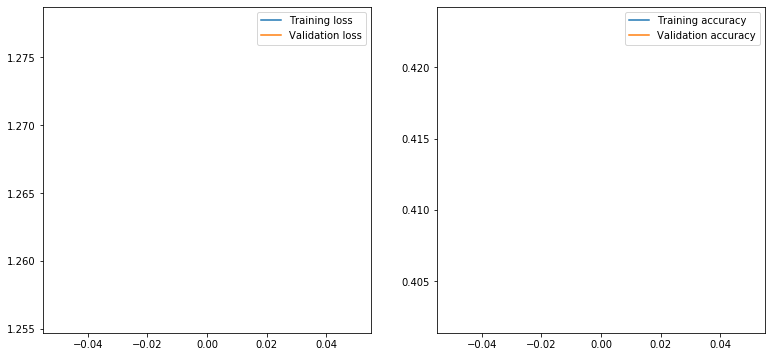

In [12]:
plt.figure(figsize=(20,6))
x = np.arange(len(history.history['acc']))

plt.subplot(1,3,1)
plt.plot(x, history.history['loss'])
plt.plot(x, history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])

plt.subplot(1,3,2)
plt.plot(x, history.history['acc'])
plt.plot(x, history.history['val_acc'])
plt.legend(['Training accuracy', 'Validation accuracy'])

## Evaluate on validation set

In [13]:
logits = model.predict(val_ds)

In [14]:
probs = tf.nn.softmax(logits).numpy()
labels_pred = np.argmax(probs, axis=1)

print('True labels: ', val_label[:10])
print('Predicted labels: ', labels_pred[:10])

True labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted labels:  [0 0 0 3 0 2 0 3 0 0]


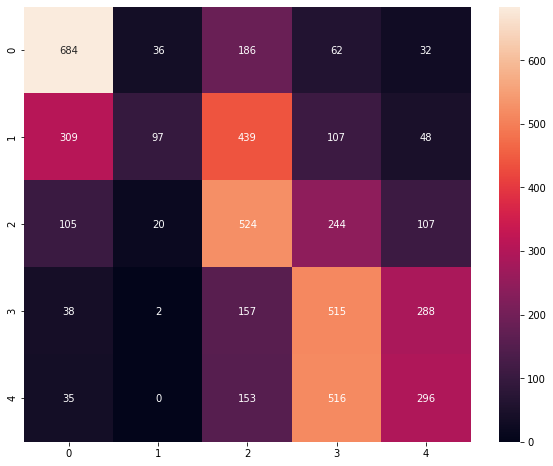

In [15]:
conf_matrix = tf.math.confusion_matrix(val_label, labels_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d")

## Interference on test set

In [16]:
test = pd.read_csv('test_clean.csv')
test

,review_id,review,review_clean
0,1,"Great danger, cool, motif and cantik2 jg model...",great danger. cool. motif cantik2 jg models. d...
1,2,One of the shades don't fit well,one shades fit well
2,3,Very comfortable,comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...,fast delivery. product expiry dec 2022. produc...
4,5,it's sooooo cute! i like playing with the glit...,sooooo cute. like playing glitters better brow...
...,...,...,...
60422,60423,Product has been succesfully ordered and shipp...,product succesfully ordered shipped quickly. g...
60423,60424,Opening time a little scared. Fear dalemnya de...,opening time little scared. fear dalemnya dest...
60424,60425,The product quality is excellent. The origina...,product quality excellent. original product. p...
60425,60426,They 're holding up REALLY well also .,'re holding really well also .


In [17]:
test_data = test['review_clean'].to_numpy().astype(str)

In [18]:
test_ds = tf.data.Dataset.from_tensor_slices((test_data))
test_ds = test_ds.batch(BATCH_SIZE)

In [19]:
logits = model.predict(test_ds)

In [20]:
probs = tf.nn.softmax(logits).numpy()
labels_pred = np.argmax(probs, axis=1)
len(labels_pred)

60427

Predictions must add 1 back to get review rating

In [21]:
test['rating'] = pd.Series(labels_pred + 1).astype(int)
test

,review_id,review,review_clean,rating
0,1,"Great danger, cool, motif and cantik2 jg model...",great danger. cool. motif cantik2 jg models. d...,3
1,2,One of the shades don't fit well,one shades fit well,3
2,3,Very comfortable,comfortable,5
3,4,Fast delivery. Product expiry is on Dec 2022. ...,fast delivery. product expiry dec 2022. produc...,4
4,5,it's sooooo cute! i like playing with the glit...,sooooo cute. like playing glitters better brow...,4
...,...,...,...,...
60422,60423,Product has been succesfully ordered and shipp...,product succesfully ordered shipped quickly. g...,4
60423,60424,Opening time a little scared. Fear dalemnya de...,opening time little scared. fear dalemnya dest...,3
60424,60425,The product quality is excellent. The origina...,product quality excellent. original product. p...,5
60425,60426,They 're holding up REALLY well also .,'re holding really well also .,4


In [22]:
test.groupby('rating').count()

,review_id,review,review_clean
rating,,,
1,6488,6488,6488
2,660,660,660
3,14858,14858,14858
4,23439,23439,23439
5,14982,14982,14982


Due to known class distribution of the test set (from Kaggle leaderboard), preditions of rating 3 are randomly converted to class 4 and class 5

Class (rating) | Frequency
---------------|----------
1 | 0.11388
2 | 0.02350
3 | 0.06051
4 | 0.39692
5 | 0.40519

In [23]:
test['rating'] = test['rating'].apply(lambda x: x if x != 3 else np.random.random_integers(2) + 3)
test

,review_id,review,review_clean,rating
0,1,"Great danger, cool, motif and cantik2 jg model...",great danger. cool. motif cantik2 jg models. d...,5
1,2,One of the shades don't fit well,one shades fit well,4
2,3,Very comfortable,comfortable,5
3,4,Fast delivery. Product expiry is on Dec 2022. ...,fast delivery. product expiry dec 2022. produc...,4
4,5,it's sooooo cute! i like playing with the glit...,sooooo cute. like playing glitters better brow...,4
...,...,...,...,...
60422,60423,Product has been succesfully ordered and shipp...,product succesfully ordered shipped quickly. g...,4
60423,60424,Opening time a little scared. Fear dalemnya de...,opening time little scared. fear dalemnya dest...,4
60424,60425,The product quality is excellent. The origina...,product quality excellent. original product. p...,5
60425,60426,They 're holding up REALLY well also .,'re holding really well also .,4


In [24]:
test.loc[:, ['review_id', 'rating']].to_csv('submission.csv', index=False)